In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle  # pip install pywaffle

%matplotlib inline

In [2]:
events = pd.read_csv('data/events.csv.gzip', compression='gzip', low_memory = False)

## **Analisis inicial**

In [3]:
events.head()

,date,event_id,ref_type,ref_hash,application_id,attributed,device_countrycode,device_os_version,device_brand,device_model,...,trans_id,user_agent,event_uuid,carrier,kind,device_os,wifi,connection_type,ip_address,device_language
0,2019-03-05 00:09:36.966,0,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,a9c0b263-acb2-4577-92c5-cbde5d7a5db1,2.248157e+17,5.516623e+18,7.531669e+18,NaN,Cable/DSL,7858558567428669000,4.077062e+17
1,2019-03-05 00:09:38.920,1,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,1cd98205-0d97-4ec2-a019-667997dbfe7a,2.248157e+17,9.977660e+17,7.531669e+18,NaN,Cable/DSL,7858558567428669000,4.077062e+17
2,2019-03-05 00:09:26.195,0,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,f02e2924-21ae-492b-b625-9021ae0a4eca,2.248157e+17,5.516623e+18,7.531669e+18,NaN,Cable/DSL,7858558567428669000,4.077062e+17
3,2019-03-05 00:09:31.107,2,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,a813cf45-a36e-4668-85e2-5395f1564e98,2.248157e+17,8.561153e+18,7.531669e+18,NaN,Cable/DSL,6324037615828123965,4.077062e+17
4,2019-03-09 21:00:36.585,3,1891515180541284343,2635154697734164782,38,False,6333597102633388268,7.391844e+18,NaN,5.960896e+18,...,NaN,NaN,63a4f0aa-e147-469f-8c55-4ca4f8d0e310,2.248157e+17,8.731902e+17,7.531669e+18,NaN,Cable/DSL,2894495631302821483,3.301378e+18


In [4]:
len(events)

2494423

In [5]:
events.isnull().sum()
# trans_id es todo null
# mientras que device_os_version, device_brand, device_city, user_agent, carrier, device_os, wifi y connection_type #
# tienen un numero muy alto de nulls (pueden trabajarse los datos pero no seran totalmente representativos de la muestra) #

date                        0
event_id                    0
ref_type                    0
ref_hash                    0
application_id              0
attributed                  0
device_countrycode          0
device_os_version     1472357
device_brand          1329460
device_model            87967
device_city           1879725
session_user_agent      11786
trans_id              2494341
user_agent            1102896
event_uuid               5099
carrier               1877989
kind                     5099
device_os             1836756
wifi                  1115551
connection_type       1881960
ip_address                  0
device_language         87819
dtype: int64

In [6]:
# Hay que chequear todas las columnas para ver si son valores unicos

## 1 - Cantidad eventos por device_brand

In [7]:
events['cantidad'] = 1
events_graficable = events.groupby('device_brand').agg({'device_brand':'count'})
events_graficable.columns= ['cantidad']

In [8]:
events_graficable = events_graficable.sort_values(by=['cantidad'],ascending=False)
events_graficable = events_graficable.head(10)
events_graficable['Alias'] = ['A','B','C','D','E','F','G','H','I','J']

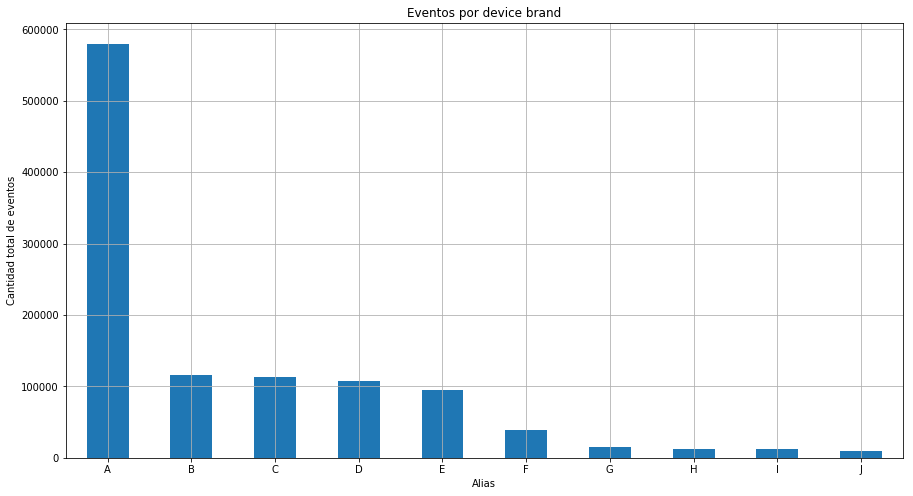

In [60]:
grph1 = events_graficable.plot.bar(grid = True, x='Alias',figsize = (15,8), legend = False, rot = 0, title = 'Eventos por device brand')
grph1.set_ylabel('Cantidad total de eventos');

## 2 - Comparacion de cantidad total y atribuida por device brand

In [10]:
events['attributed'].value_counts()

False    2489324
True        5099
Name: attributed, dtype: int64

In [11]:
events_graficable2 = events.groupby('device_brand').agg({'device_brand':'count', 'attributed':'sum'})
events_graficable2.columns= ['total', 'attributed']

In [12]:
events_graficable2 = events_graficable2.sort_values(by=['total'],ascending=False)
events_graficable2 = events_graficable2.head(10)
events_graficable2['Alias'] = ['A','B','C','D','E','F','G','H','I','J']

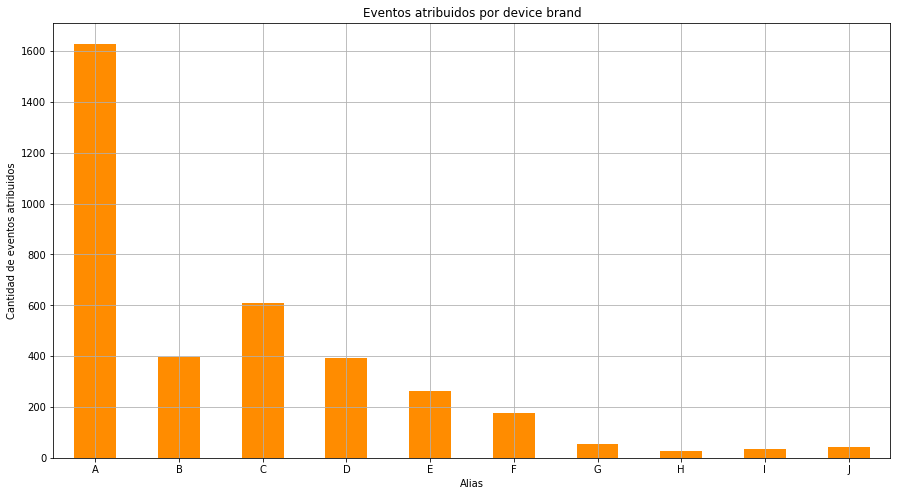

In [56]:
grph2 = events_graficable2.plot.bar(y = 'attributed', x='Alias',figsize = (15,8), grid = True, legend = False, color = 'darkorange', rot = 0, title = 'Eventos atribuidos por device brand')
grph2.set_ylabel('Cantidad de eventos atribuidos');

### Se puede apreciar una cierta tendencia que a mayor numero de events -> mayor numero de attributed sin importar la marca
Caso especial en C (eventos mas propensos a ser atribuidos a jampp a menor cantidad)

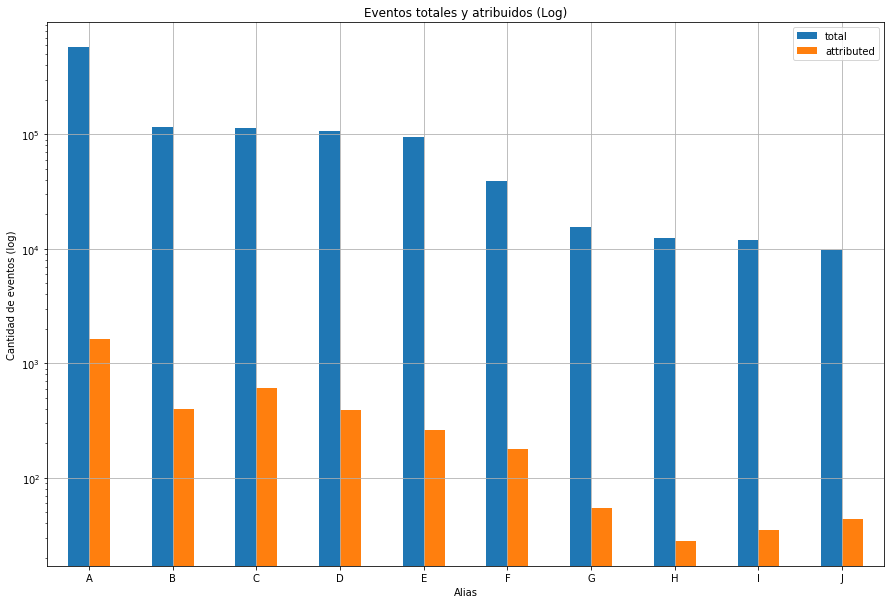

In [57]:
grph3 = events_graficable2.plot.bar( x='Alias',figsize = (15,10), grid = True, title = 'Eventos totales y atribuidos (Log)', rot = 0)
grph3.set_yscale('log')
grph3.set_ylabel('Cantidad de eventos (log)');

## 3 - Eventos mas frecuentes segun dia y hora

In [15]:
events['date'] = pd.to_datetime(events['date'])
events['hour'] = events.date.dt.hour
events['day'] = events.date.dt.day

In [16]:
events_day_hour = events.groupby(['day','hour']).agg({'event_id':'count'})
events_day_hour = events_day_hour.reset_index()
events_day_hour = events_day_hour.rename(columns={'event_id':'event_counts'})
events_day_hour.head()

,day,hour,event_counts
0,5,0,17154
1,5,1,15926
2,5,2,13818
3,5,3,12110
4,5,4,8225


'Sharex = False' es porque no me mostraba el eje x (ni idea que onda) - Lucas

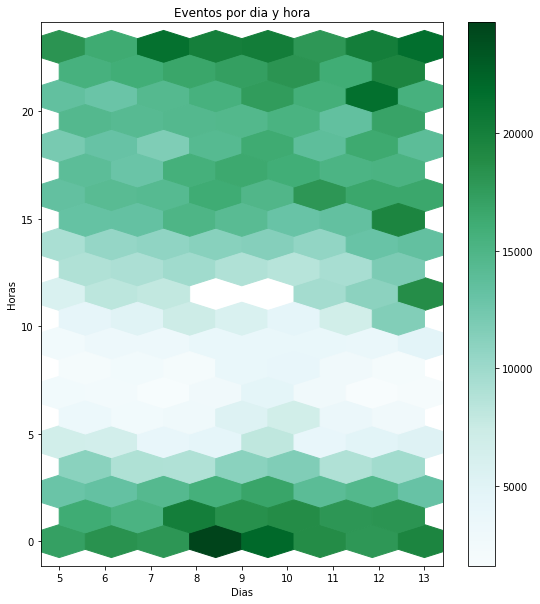

In [48]:
grph3 = events_day_hour.plot.hexbin(x='day',y='hour', C= 'event_counts', figsize = (9,10), gridsize = (7,10),sharex=False, title = 'Eventos por dia y hora')
grph3.set_xlabel('Dias')
grph3.set_ylabel('Horas');

## 4 - Cantidad de eventos por hora

In [20]:
evnt_hora = events.groupby('hour').agg({'hour':'count'})

In [23]:
evnt_hora.columns = ['count']

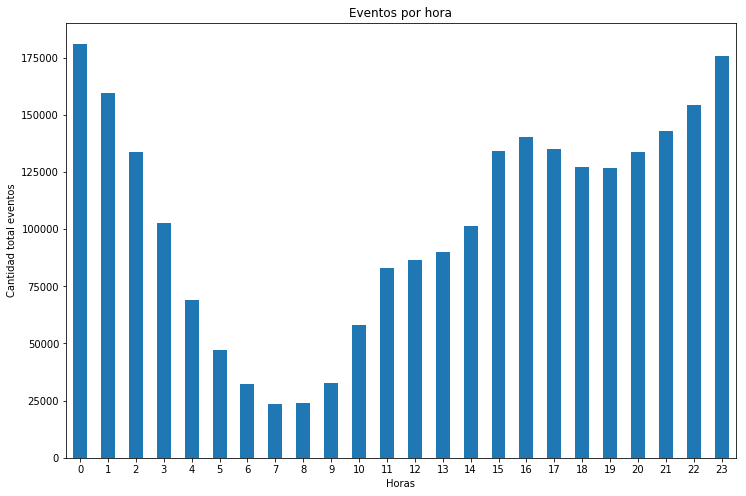

In [47]:
grph4 = evnt_hora.plot.bar(figsize = (12,8), legend = False, rot = 0, title = 'Eventos por hora')
grph4.set_ylabel('Cantidad total eventos')
grph4.set_xlabel('Horas');

## 5 - Cantidad de eventos por dia

In [62]:
evnt_dia = events.groupby('day').agg({'day':'count'})

In [63]:
evnt_dia.columns = ['count']

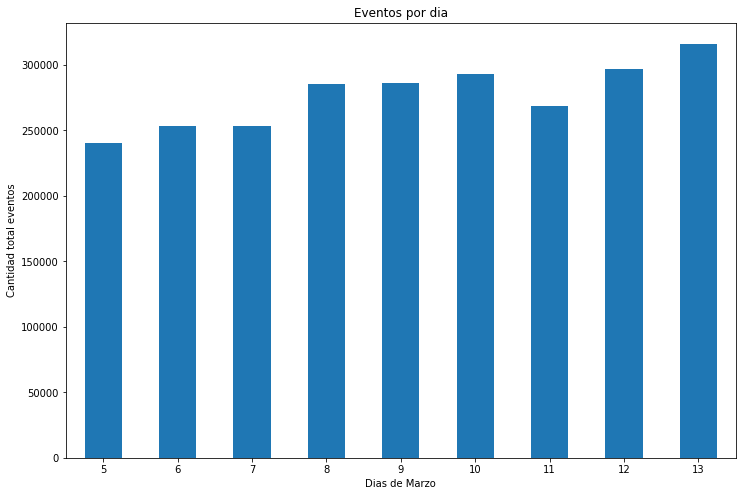

In [64]:
grph5 = evnt_dia.plot.bar(figsize = (12,8), legend = False, rot = 0, title = 'Eventos por dia')
grph5.set_ylabel('Cantidad total eventos')
grph5.set_xlabel('Dias de Marzo');

## 6 - Cantidad de eventos totales y atributed (malisimo)

In [65]:
evnt_attributed = events.groupby('attributed').agg({'attributed':'count'})

In [71]:
evnt_attributed.columns = ['count']

In [79]:
evnt_attributed.reset_index(inplace = True)

In [102]:
evnt_attributed.drop(columns='index', inplace = True)

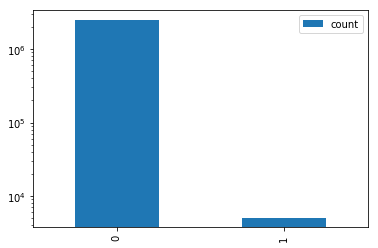

In [104]:
grph6 = evnt_attributed.plot.bar()
grph6.set_yscale('log')

## 7 - Idioma de los dispositivos

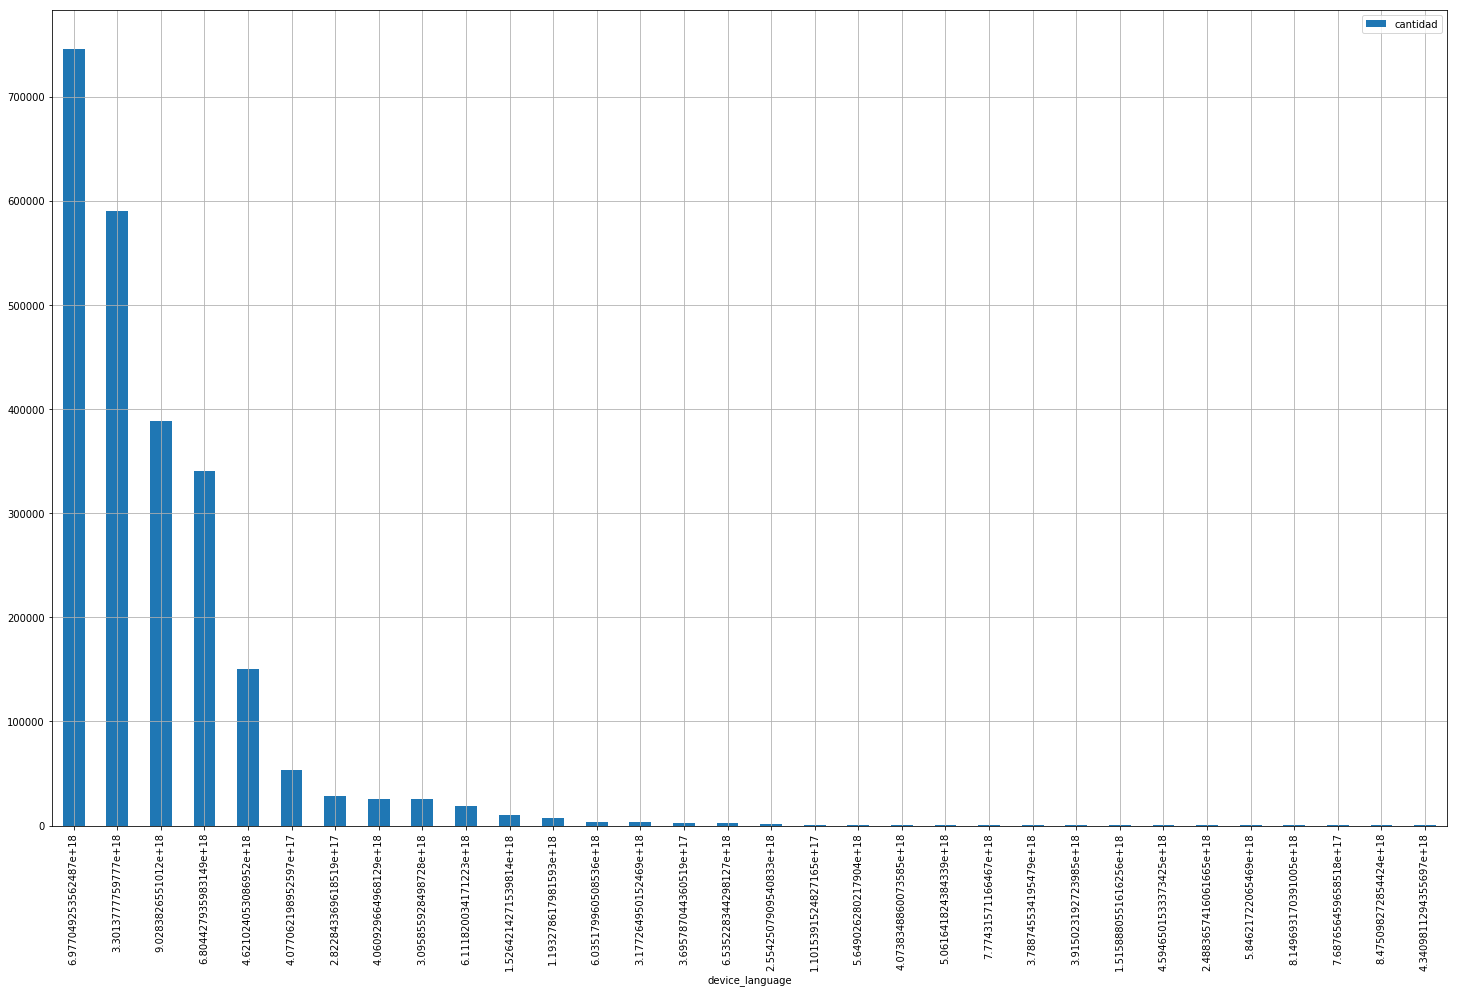

In [26]:
graph6 = events.groupby('device_language').agg({'device_language':'count'})
graph6.columns = ['cantidad']
graph6 = graph6.sort_values(by='cantidad',ascending = False)
graph6 = graph6[graph6['cantidad'] > 200]
graph6 = graph6.plot.bar(grid = True, figsize = (25,15))